In [1]:
pip install gurobipy

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import gurobipy as gp

In [3]:
iter_count = 0
prob_val = 0.125
scenario_probs = {}
r =2 
max_iter = 10
k = 0

scenario_demands = {
    "S1": [1, 3, 3, 3],
    "S2": [1, 3, 3, 1],
    "S3": [1, 3, 1, 3],
    "S4": [1, 3, 1, 1],
    "S5": [1, 1, 3, 3],
    "S6": [1, 1, 3, 1],
    "S7": [1, 1, 1, 3],
    "S8": [1, 1, 1, 1]
}

scenario_outcomes = []

for scenario_id, demand_vals in scenario_demands.items():
    model_instance = gp.Model()
    
    Periods = range(1, 5)
    Scenarios = range(1, 9)

    x = {period: model_instance.addVar(name=f'x_{period}') for period in Periods}
    w = {period: model_instance.addVar(name=f'w_{period}') for period in Periods}
    y = {period: model_instance.addVar(name=f'y_{period}') for period in Periods}
    y[0] = 0  # Initial state
   
    model_instance.update()

    model_instance.setObjective(gp.quicksum(x[period] + 3 * w[period] + 0.5 * y[period] for period in Periods), sense=gp.GRB.MINIMIZE)

    model_instance.addConstr(x[1] + w[1] - y[1] == 1, name='start_balance')
    for period in Periods:
        model_instance.addConstr(x[period] <= 2, name=f'x_cap_{period}')
    for period in range(2, 5):
        model_instance.addConstr(x[period] + w[period] + y[period - 1] - y[period] == demand_vals[period - 1], name=f'flow_balance_{period}')

    model_instance.optimize()

    result_entry = {
        "ScenarioID": scenario_id,
        "ModelStatus": model_instance.status,
        "Objective": model_instance.objVal,
        "VariableAssignments": {period: (x[period].x, w[period].x, y[period].x) for period in Periods}
    }
    scenario_outcomes.append(result_entry)

for outcome in scenario_outcomes:
    print(f"Scenario: {outcome['ScenarioID']}")
    print(f"Optimal Objective: {outcome['Objective']}")
    print("Variable Assignments:")
    for period, (x_val, w_val, y_val) in outcome["VariableAssignments"].items():
        print(f" Period {period}: x = {x_val}, w = {w_val}, y = {y_val}")
    
    print("---" * 10)


Restricted license - for non-production use only - expires 2025-11-24
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 8 rows, 12 columns and 19 nonzeros
Model fingerprint: 0xf92d2bd0
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-01, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+00]
Presolve removed 4 rows and 0 columns
Presolve time: 0.01s
Presolved: 4 rows, 12 columns, 15 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.000000e+01   0.000000e+00      0s
       5    1.4500000e+01   0.000000e+00   0.000000e+00      0s

Solved in 5 iterations and 0.02 seconds (0.00 work units)
Optimal objective  1.450000000e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 

In [4]:
expected_objective = 0
for outcome in scenario_outcomes:
    expected_objective += prob_val * outcome["Objective"]
    print(outcome["Objective"])

14.5
10.5
9.0
6.5
10.0
6.5
6.5
4.0


In [5]:
pi = {}
for period in Periods:
    for scenario in Scenarios:
        pi[(period, scenario)] = 0
        
Xbar = {}
for outcome in scenario_outcomes:
    scenario_id = outcome["ScenarioID"]
    decision_values = outcome["VariableAssignments"]
    Xbar[scenario_id] = 0
    for period in Periods:
        x_hat_ts = decision_values[period][0]  # Assuming x[t] is the first element in the tuple
        Xbar[scenario_id] += prob_val * x_hat_ts

Xbar_int = {int(scenario_id[1:]): value for scenario_id, value in Xbar.items()}

In [6]:
Xbar_int

{1: 1.0, 2: 0.875, 3: 1.0, 4: 0.75, 5: 1.0, 6: 0.75, 7: 0.75, 8: 0.5}

In [7]:
all_solutions = {}
all_Xbars = {}

for k in range(1, max_iter + 1):
    print("Iteration:", k)

    Periods = range(1, 5)
    Scenarios = range(1, 9)

    solutions_k = []

    for scenario_id, demand_values in scenario_demands.items():
        optimization_model = gp.Model()

        x = {period: optimization_model.addVar(name=f'x_{period}') for period in Periods}
        w = {period: optimization_model.addVar(name=f'w_{period}') for period in Periods}
        y = {period: optimization_model.addVar(name=f'y_{period}') for period in Periods}
        y[0] = 0  

        obj_expression = 0
        for period in Periods:
            for scenario in Scenarios:
                obj_expression += (x[period] + 3 * w[period] + 0.5 * y[period])
                obj_expression += pi[(period, scenario)] * x[period]
                obj_expression += r / 2 * (x[period] - Xbar_int[scenario]) ** 2 
        optimization_model.setObjective(obj_expression, gp.GRB.MINIMIZE)

        optimization_model.addConstr(x[1] + w[1] - y[1] == 1, name='initial_balance')
        for period in Periods:
            optimization_model.addConstr(x[period] <= 2, name=f'production_cap_{period}')
        for period in range(2, 5):
            optimization_model.addConstr(x[period] + w[period] + y[period - 1] - y[period] == demand_values[period - 1], name=f'demand_satisfaction_{period}')

        optimization_model.optimize()

        solution = {
            "ScenarioID": scenario_id,
            "ModelStatus": optimization_model.status,
            "ObjectiveValue": optimization_model.objVal,
            "DecisionVariables": {period: (x[period].x, w[period].x, y[period].x) for period in Periods}
        }
        solutions_k.append(solution)

    for solution in solutions_k:
        print(f"Scenario: {solution['ScenarioID']}")
        if solution['ModelStatus'] == gp.GRB.OPTIMAL:
            print(f"Objective: {solution['ObjectiveValue']}")
            print("Variable Assignments:")
            for period, (x_val, w_val, y_val) in solution["DecisionVariables"].items():
                print(f" Period {period}: x = {x_val}, w = {w_val}, y = {y_val}, demand = {demand_values[period - 1]}")
        else:
            print("Optimal solution not found.")

    all_solutions[k] = solutions_k

    Xbar_current = {}
    for solution in solutions_k:
        scenario_id = solution["ScenarioID"]
        decision_values = solution["DecisionVariables"]
        Xbar_current[scenario_id] = sum(prob_val * x_val for period, (x_val, w_val, y_val) in decision_values.items())

    Xbar_int = {int(scenario_id[1:]): value for scenario_id, value in Xbar_current.items()}

    all_Xbars[k] = Xbar_int

    for scenario in Scenarios:
        for period in Periods:
            pi[(period, scenario)] += r * (x_hat_ts - Xbar_int[scenario])


Iteration: 1
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 8 rows, 12 columns and 19 nonzeros
Model fingerprint: 0x7276f954
Model has 4 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+00, 2e+01]
  QObjective range [2e+01, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+00]
Presolve removed 4 rows and 0 columns
Presolve time: 0.01s
Presolved: 4 rows, 12 columns, 15 nonzeros
Presolved model has 4 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 3.000e+00
 Factor NZ  : 1.000e+01
 Factor Ops : 3.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual 

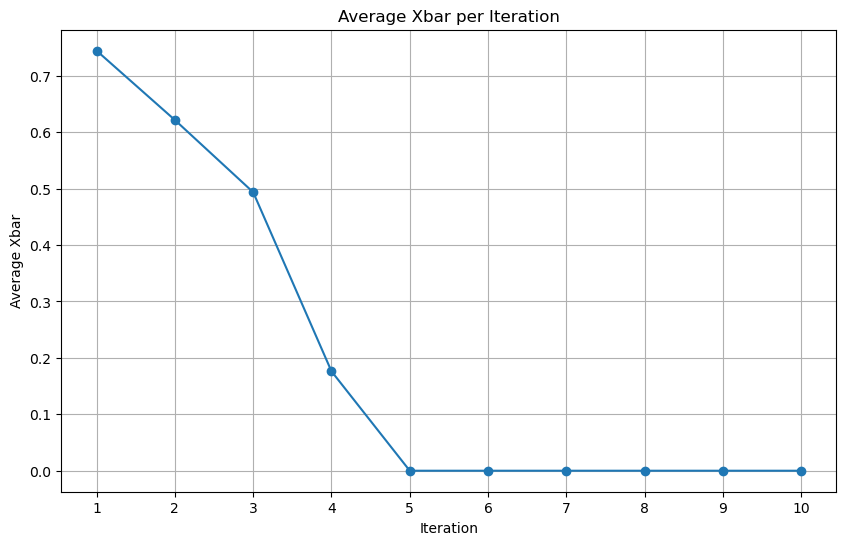

In [8]:
import matplotlib.pyplot as plt

avg_Xbars = []
for k in range(1, max_iter + 1):
    Xbar_values = all_Xbars[k]
    avg_Xbar = sum(Xbar_values.values()) / len(Xbar_values)
    avg_Xbars.append(avg_Xbar)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_iter + 1), avg_Xbars, marker='o', linestyle='-')
plt.title('Average Xbar per Iteration')
plt.xlabel('Iteration')
plt.ylabel('Average Xbar')
plt.grid(True)
plt.xticks(range(1, max_iter + 1))
plt.show()


In [13]:
import pandas as pd

pd.set_option('display.max_rows', None)

dfs = []

for k in range(1, max_iter + 1):
    solutions = all_solutions[k]

    data = []
    for solution in solutions:
        scenario_data = {
            'Iteration': k,
            'Scenario': solution['ScenarioID'],
            'X1': solution['DecisionVariables'][1][0],
            'X2': solution['DecisionVariables'][2][0],
            'X3': solution['DecisionVariables'][3][0],
            'X4': solution['DecisionVariables'][4][0]
        }
        data.append(scenario_data)

    df = pd.DataFrame(data)
    df.set_index(['Iteration', 'Scenario'], inplace=True)
    dfs.append(df)

final_df = pd.concat(dfs)

print("Values of X1, X2, X3, and X4 for each scenario across all iterations:")
print(final_df)


Values of X1, X2, X3, and X4 for each scenario across all iterations:
                              X1            X2            X3            X4
Iteration Scenario                                                        
1         S1        1.578125e+00  1.828125e+00  1.828125e+00  1.828125e+00
          S2        1.578125e+00  1.828125e+00  1.828125e+00  1.000000e+00
          S3        1.578125e+00  1.828125e+00  1.578125e+00  1.828125e+00
          S4        1.578125e+00  1.828125e+00  1.000000e+00  1.000000e+00
          S5        1.328125e+00  1.578125e+00  1.828125e+00  1.828125e+00
          S6        1.328125e+00  1.578125e+00  1.828125e+00  1.000000e+00
          S7        1.078125e+00  1.328125e+00  1.578125e+00  1.828125e+00
          S8        1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00
2         S1        1.238281e+00  1.488281e+00  1.488281e+00  1.488281e+00
          S2        1.238281e+00  1.488281e+00  1.488281e+00  1.000000e+00
          S3        1.238281e+

In [10]:
import pandas as pd

Xbar_data = []
objective_data = []

for k in range(1, max_iter + 1):
    Xbar_values = all_Xbars.get(k, {})
    solution_values = all_solutions.get(k, [])

    Xbar_iteration_data = {"Iteration": k}
    objective_iteration_data = {"Iteration": k, "Z": 0}

    for scenario, Xbar_value in Xbar_values.items():
        Xbar_iteration_data[f"Xbar_{scenario}"] = Xbar_value

    for solution in solution_values:
        scenario = int(solution["ScenarioID"][1:])
        objective = solution["ObjectiveValue"]
        objective_iteration_data[f"Objective_{scenario}"] = objective
        objective_iteration_data["Z"] += prob_val * objective

    Xbar_data.append(Xbar_iteration_data)
    objective_data.append(objective_iteration_data)

Xbar_df = pd.DataFrame(Xbar_data)
objective_df = pd.DataFrame(objective_data)

Xbar_df.set_index("Iteration", inplace=True)
objective_df.set_index("Iteration", inplace=True)

Xbar_df = Xbar_df.round(5)
objective_df = objective_df.round(5)

print("Xbar Values:")
print(Xbar_df)
print("\nObjective Values:")
print(objective_df)

Xbar Values:
            Xbar_1   Xbar_2   Xbar_3   Xbar_4   Xbar_5   Xbar_6   Xbar_7  \
Iteration                                                                  
1          0.88281  0.77930  0.85156  0.67578  0.82031  0.71680  0.72656   
2          0.71289  0.65186  0.68164  0.59082  0.65186  0.59082  0.59082   
3          0.49341  0.49341  0.49341  0.49341  0.49341  0.49341  0.49341   
4          0.17615  0.17615  0.17615  0.17615  0.17615  0.17615  0.17615   
5          0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000   
6          0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000   
7          0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000   
8          0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000   
9          0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000   
10         0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000   

            Xbar_8  
Iteration           
1          0.50000  
2          